# 训练

In [1]:
from tensorflow import keras

## 定义网络

In [47]:
def Mobilenet_v2(input_size,weights,Dropout_rate,Trainable,alpha = 0.35):
    base_model = keras.applications.MobileNetV2(
        input_shape=(input_size, input_size, 3),
        alpha=alpha,
        weights=weights,
        include_top=False
    )
    inputs = keras.Input(shape=(input_size, input_size,3))

    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(inputs)
    x = base_model(x, training=False)
    if Trainable:
        base_model.trainable =True
    else:
        base_model.trainable = False
        print("特征层已冻结")
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(Dropout_rate, name='Dropout')(x)
    outputs = keras.layers.Dense(15, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    return model

## 设定超参数

In [3]:
epochs = 100
input_size=128
lr =1e-4
Dropout_rate=0.3
batch_size =128

In [4]:
model = Mobilenet_v2(input_size,weights='imagenet',Dropout_rate=Dropout_rate,Trainable=True)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 mobilenetv2_0.35_128 (Funct  (None, 4, 4, 1280)       410208    
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 Dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 15)                19215 

## 读取数据集
+ 这里仅进行简单的增强
+ 这里的验证集是从训练集中划分的，实际训练最好有独立的验证集。

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_root = "./train/"

train_generator = ImageDataGenerator(rotation_range=360,
                                     zoom_range  =0.2,
                                     horizontal_flip = True,
                                     validation_split =0.2
                                     )
train_dataset = train_generator.flow_from_directory(batch_size=batch_size,
                                                    directory=train_root,
                                                    shuffle=True,
                                                    target_size=(input_size,input_size),
                                                    subset='training')
valid_dataset = train_generator.flow_from_directory(batch_size=batch_size,
                                                   directory=train_root,
                                                    shuffle=True,
                                                    target_size=(input_size,input_size),
                                                    subset='validation')
print(train_dataset.class_indices)

Found 1903 images belonging to 15 classes.
Found 466 images belonging to 15 classes.
{'大客车': 0, '小汽车': 1, '榴莲': 2, '橙子': 3, '火车': 4, '牛': 5, '狗': 6, '猪': 7, '猫': 8, '苹果': 9, '葡萄': 10, '轮船': 11, '飞机': 12, '香蕉': 13, '马': 14}


In [6]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])


## 开始训练
建立三个回调，学习率降低，早停，权重保存。

In [8]:

import time
import os
save_path = './models_save/%s' % (time.strftime('%Y_%m_%d_%H_%M_%S'))

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10,verbose=1)
early_stop =keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,verbose=1)
save_weights = keras.callbacks.ModelCheckpoint(save_path + "/model_{epoch:02d}_{val_accuracy:.4f}.h5",
                                                   save_best_only=True, monitor='val_accuracy')
hist = model.fit(train_dataset, 
                 epochs=epochs,
                 validation_data=valid_dataset,
                  callbacks=[save_weights,early_stop,reduce_lr]
                 )

Epoch 1/5
15/15 [==============================] - 7s 491ms/step - loss: 2.4283 - accuracy: 0.2533 - val_loss: 1.7722 - val_accuracy: 0.4614 - lr: 1.0000e-04
Epoch 2/5
15/15 [==============================] - 7s 439ms/step - loss: 1.4472 - accuracy: 0.5428 - val_loss: 1.0559 - val_accuracy: 0.6652 - lr: 1.0000e-04
Epoch 3/5
15/15 [==============================] - 7s 434ms/step - loss: 0.9432 - accuracy: 0.6821 - val_loss: 0.8471 - val_accuracy: 0.7039 - lr: 1.0000e-04
Epoch 4/5
15/15 [==============================] - 7s 444ms/step - loss: 0.7343 - accuracy: 0.7441 - val_loss: 0.7182 - val_accuracy: 0.7511 - lr: 1.0000e-04
Epoch 5/5
15/15 [==============================] - 7s 443ms/step - loss: 0.6211 - accuracy: 0.7819 - val_loss: 0.6115 - val_accuracy: 0.7961 - lr: 1.0000e-04


## 可视化

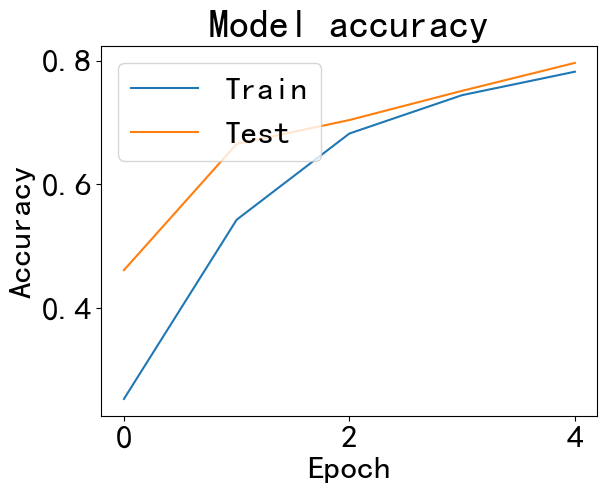

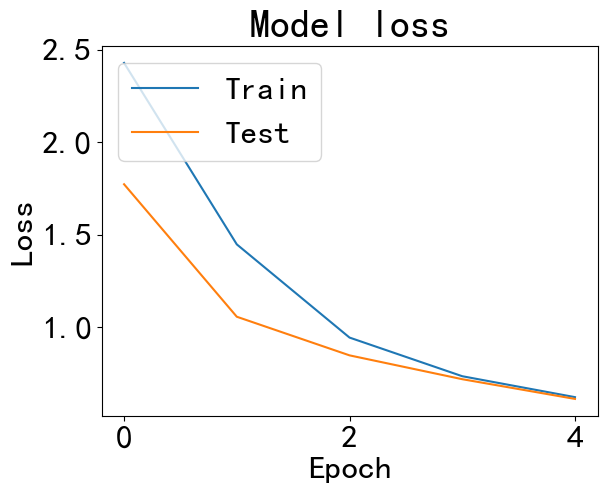

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'{save_path}/acc')

# 绘制训练 & 验证的损失值
plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'{save_path}/loss')

df = pd.DataFrame.from_dict(hist.history)
df.to_csv(f'{save_path}/hist.csv', encoding='utf-8', index=False)

## 绘制混淆矩阵

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib
font = {'family': 'SimHei', "size": 24}
matplotlib.rc('font', **font)

def get_confusion_matrix(label,y_pred,cls):
    Confusion_Matrix = confusion_matrix(label, y_pred)
    cls_sum = Confusion_Matrix.sum(axis=0)
    Confusion_Matrix = Confusion_Matrix/cls_sum#归一化
    print(np.around(Confusion_Matrix,3))
    Confusion_Matrix=Confusion_Matrix*255
    plt.matshow(Confusion_Matrix, cmap=plt.cm.Greens)
    plt.xlabel('predict')
    plt.ylabel('true')
    xlocations = np.array(range(len(cls)))
    print(cls)
    print(xlocations)
    plt.xticks(xlocations, cls, rotation=0)
    plt.yticks(xlocations, cls)
    plt.show()

# 量化

## 测试

In [40]:
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def tflite_pre(modelpath,dataset_root,batch_size=128,input_size = 96):
    test_root = dataset_root

    valid_generator = ImageDataGenerator()
    valid_dataset = valid_generator.flow_from_directory(batch_size=batch_size,
                                                        directory=test_root,
                                                        shuffle=True,
                                                        target_size=(input_size, input_size))
    interpreter = tf.lite.Interpreter(model_path=modelpath)

    input_index = interpreter.get_input_details()
    output_index = interpreter.get_output_details()

    acc=0
    sum=0
    labels=np.array([])
    predictions=np.array([])
    with tqdm(valid_dataset,desc='test_tflite') as d:
        for batch_number, (img, label) in enumerate(d):
            batch = len(label)
            label = label.argmax(axis=1)
            sum += batch
            interpreter.resize_tensor_input(input_index[0]['index'], (batch, input_size, input_size, 3))
            interpreter.resize_tensor_input(output_index[0]['index'], (batch, 15))
            interpreter.allocate_tensors()
            interpreter.set_tensor(input_index[0]['index'], np.array(img, dtype=np.float32))
            interpreter.invoke()
            output = interpreter.get_tensor(output_index[0]['index'])
            output = output.argmax(axis=1)
            correct_pre = np.where(output == label, 1, 0)
            acc += correct_pre.sum()

            predictions =np.append(predictions,output)
            labels=np.append(labels,label)

            if sum >= len(valid_dataset) * batch_size:
                break
            d.set_postfix(acc = acc/sum)
            d.update()
    print("小类准确率：", acc / sum)
    get_confusion_matrix(labels,predictions,valid_dataset.class_indices)
    return acc/sum

## 量化

In [41]:
from tensorflow.keras.models import load_model
import json
import time
import os
def convert_to_tf_lite(model_path,valid_input_size,valid_path=None):
    model = load_model(model_path)

    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.post_training_quantize=True
    tflite_model = converter.convert()

    start_time = time.strftime('%m_%d_%H_%M')
    name = model_path.split('/')[-1][:-3]

    save_root = "./tflite_model/%s_" % start_time +'_' + name
    os.mkdir(save_root)

    save_path = save_root+"/"+str(valid_input_size)+name+'.tflite'

    with open(save_path, 'wb') as f:
        f.write(tflite_model)
    if valid_path!=None:
        acc = tflite_pre(modelpath=save_path,
                         dataset_root=valid_path,
                         input_size=valid_input_size)
        remark = {'model_path':model_path,'input_size':valid_input_size,'valid_path':valid_path,'acc':acc}
        with open(save_root+"/remark.json",'w',encoding='utf-8') as f:
            json.dump(remark,f)

In [ ]:
convert_to_tf_lite(model_path='./models_save/2023_01_03_18_11_12/model_27_0.8948.h5',
                   valid_input_size=input_size,
                   valid_path='./train')

# 超参搜索

## 简单例子
先来个简单的例子

### 定义超模型

In [1]:
from tensorflow import keras
import keras_tuner

class HyperModel(keras_tuner.HyperModel):
    def model(self,units,num_layers,lr):
        model = keras.Sequential()
        model.add(keras.layers.Rescaling(scale=1 / 127.5, offset=-1))
        model.add(keras.layers.Flatten())
        for i in range(num_layers):
            model.add(keras.layers.Dense(units, activation='relu'))
        model.add(keras.layers.Dropout(rate=0.3))
        model.add(keras.layers.Dense(10, activation="softmax"))
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )
        return model
    def build(self, hp):

        units = hp.Int("units", min_value=64, max_value=256, step=32)
        num_layers = hp.Int("num_layers",min_value=1,max_value=3)
        lr = hp.Float("lr",min_value=1e-5,max_value=1e-3,sampling="log")

        return self.model(units,num_layers,lr) 
    def fit(self, hp, model, x_train,y_train, **kwargs):
        return model.fit(
            x_train,
            y_train,
            **kwargs
        )

### 利用mnist测试

In [2]:
from tensorflow import keras
import numpy as np

(x, y), (x_test, y_test) = keras.datasets.mnist.load_data()

x = np.expand_dims(x,axis=-1)
x_test = np.expand_dims(x_test,axis=-1)

num_classes =10
y = keras.utils.to_categorical(y, num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)


In [33]:
tuner = keras_tuner.RandomSearch(
    HyperModel(),
    objective="val_accuracy",
    max_trials=10,
    overwrite=True,
    directory="my_dir",
    project_name="tune_hypermodel",
)

In [34]:
tuner.search(x,y,epochs=2,batch_size=128,validation_data=(x_test, y_test),workers =8)

Trial 10 Complete [00h 00m 04s]
val_accuracy: 0.9144999980926514

Best val_accuracy So Far: 0.9641000032424927
Total elapsed time: 00h 00m 38s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()


In [ ]:
hypermodel = HyperModel()
best_hp = tuner.get_best_hyperparameters()[0]
model = hypermodel.build(best_hp)
hypermodel.fit(best_hp, model, x, y, epochs=20,batch_size=128,validation_data=(x_test, y_test),workers =8)

In [37]:
model.save('demo_hypermodel.h5')

In [38]:
from tensorflow.keras.models import load_model
model = load_model('demo_hypermodel.h5')
model.evaluate(
    x_test,
    y_test,
    batch_size=128,
)

79/79 [==============================] - 0s 4ms/step - loss: 0.0770 - accuracy: 0.9808


[0.07700708508491516, 0.9807999730110168]

## 超·MobileNetV2
正式开始

In [3]:
def Mobilenet_v2(input_size,weights,Dropout_rate,Trainable,alpha = 0.35):
    base_model = keras.applications.MobileNetV2(
        input_shape=(input_size, input_size, 3),
        alpha=alpha,
        weights=weights,
        include_top=False
    )
    inputs = keras.Input(shape=(input_size, input_size,3))

    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(inputs)
    x = base_model(x, training=False)
    if Trainable:
        base_model.trainable =True
    else:
        base_model.trainable = False
        print("特征层已冻结")
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(Dropout_rate, name='Dropout')(x)
    outputs = keras.layers.Dense(15, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    return model

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
class HyperMobilenet_v2(keras_tuner.HyperModel):
    def __init__(self,input_size,batch_size,train_root):
        super(keras_tuner.HyperModel, self).__init__()
        self.input_size = input_size
        self.batch_size = batch_size
        self.train_root = train_root
    def model(self,Dropout_rate,lr):
        model = Mobilenet_v2(
            input_size=self.input_size,
            weights='imagenet',
            Dropout_rate=Dropout_rate,
            Trainable=True
        )
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                    loss=keras.losses.CategoricalCrossentropy(),
                    metrics=["accuracy"])
        return model
    def build(self, hp):
        lr = hp.Float("lr",min_value=1e-5,max_value=1e-3,sampling="log")
        Dropout_rate = hp.Choice("Dropout_rate",values =[0.1,0.2,0.3,0.4,0.5,0.6])
        return self.model(Dropout_rate,lr) 
    
    def dataset(self, hp):

        train_root = self.train_root

        zoom_range = hp.Float("zoom_range",min_value=0.1,max_value=0.3,sampling="linear")
        channel_shift_range = hp.Int("channel_shift_range",min_value=0,max_value=30,step=10)

        train_generator = ImageDataGenerator(rotation_range=360,
                                            zoom_range =zoom_range,
                                            horizontal_flip = True,
                                            validation_split =0.2,
                                            channel_shift_range =channel_shift_range
                                            )
        train_dataset = train_generator.flow_from_directory(batch_size=self.batch_size,
                                                            directory=train_root,
                                                            shuffle=True,
                                                            target_size=(self.input_size,self.input_size),
                                                            subset='training')
        valid_dataset = train_generator.flow_from_directory(batch_size=self.batch_size,
                                                            directory=train_root,
                                                            shuffle=True,
                                                            target_size=(self.input_size,self.input_size),
                                                            subset='validation')
        return train_dataset,valid_dataset

    def fit(self, hp, model,**kwargs):
        
        train_dataset,valid_dataset = self.dataset(hp)

        return model.fit(
            train_dataset,
            validation_data=valid_dataset,
            **kwargs
        ) 

In [6]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel =HyperMobilenet_v2(input_size=128,batch_size=128,train_root='./train/'),
    objective="val_accuracy",
    max_trials=50,
    overwrite=True,
    directory="my_dir",
    project_name="tune_hypermodel",
)
tuner.search(epochs=10,workers=8)

Trial 50 Complete [00h 00m 24s]
val_accuracy: 0.8133047223091125

Best val_accuracy So Far: 0.8476395010948181
Total elapsed time: 00h 23m 59s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

In [20]:
hypermodel = HyperMobilenet_v2(input_size=128,batch_size=128,train_root='./train/')
best_hp = tuner.get_best_hyperparameters()[0]
model = hypermodel.build(best_hp)

In [ ]:
import time
import os
save_path = './models_save/%s' % (time.strftime('%Y_%m_%d_%H_%M_%S'))
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10,verbose=1)
early_stop =keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15,verbose=1)
save_weights = keras.callbacks.ModelCheckpoint(save_path + "/model_{epoch:02d}_{val_accuracy:.4f}.h5",
                                                   save_best_only=True, monitor='val_accuracy')

hypermodel.fit(
    best_hp, 
    model,
    epochs=100,
    workers =8,
    callbacks=[save_weights,early_stop,reduce_lr]
    )